# Neural Network Hw6 Write Up and Code
Hi! In this document you'll find all of my code and a paper I wrote on a generalization of neural networks called GANNs. I prove that GANNs are a strict superset of all neural networks and infact I provide a general backpropagation algorithm whose derivation is attached as the next document (a supplement to the statement I make in the paper). 

I hope that suffices as an answer to the first question. Of the assignment.

In [2]:
%matplotlib inline  
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from IPython import display
import random

%matplotlib inline  

In [3]:
# LOAD TRAINING DATA
train_mat = scipy.io.loadmat('train.mat')
train_images_raw = train_mat['train_images'].T
train_images_corrected = []
for i in range(len(train_images_raw)):
    train_images_corrected.append(train_images_raw[i].T.ravel())
train_images_corrected = np.array(train_images_corrected)
train_labels_corrected = train_mat['train_labels'].ravel()

#LOAD TESTING DATA

test_mat = scipy.io.loadmat('test.mat')
test_images_raw =test_mat['test_images']
test_images_corrected = []
for i in range(len(test_images_raw)):
    test_images_corrected.append(test_images_raw[i].ravel())
test_images_corrected = np.array(test_images_corrected)

In [4]:
# Preprocess the data
def normalize(X):
    Xprime = (X /255.0)
   
    return Xprime

def sep_categories(Y, rangeY):
      return np.array([np.array([(i == y) for i in range(rangeY)])*1 for y in Y])


X_tr = normalize(train_images_corrected)
Y_tr = sep_categories(train_labels_corrected, 10)
X_te = normalize(test_images_corrected)

#plt.imshow(X_tr[14515].reshape(28,28), interpolation='nearest', cmap=plt.cm.ocean, extent=(0.5,10.5,0.5,10.5))
#plt.colorbar()
#plt.show()

In [5]:
# Data separation
shuffle = np.random.permutation(np.arange(len(X_tr)))
X_tr, Y_tr = X_tr[shuffle], Y_tr[shuffle]

validation_count = 10000
X_va, Y_va = X_tr[0:validation_count], Y_tr[0:validation_count]
X_tr, Y_tr = X_tr[validation_count:], Y_tr[validation_count:]

In [6]:
class sigmoid:
    def __init__(self, func, derivative):
        self.func = func
        self.prime = derivative
    def __call__(self, x):
        return self.func(x)
logistic = sigmoid(scipy.special.expit, lambda x: scipy.special.expit(x)*(1 -scipy.special.expit(x)))

def hat(x):
    return np.append(x, [1])

def scratch(mat):
    return mat[:-1, :] #Todo improve speed to O(1)
    
    
# Neural networkl
class ann:
    def __init__(self, neuro_c, sigma=logistic):
        self.L = len(neuro_c) - 1
        self.W = [None] * (len(neuro_c) - 1)
        self.net = [None] * (len(neuro_c) -1)
        self.O = [None] * len(neuro_c) 
        
        self.sigma = sigma

        
        for i in range(len(neuro_c)-1):
            self.W[i] = np.random.rand(neuro_c[i]+1, neuro_c[i+1]) * 2 -1 # 1 for bias

    
    """Performs the feedforward portion of the algorithm. Returns the output."""
    def feed_forward(self, x):
        self.O[0] = x
        for i, w in enumerate(self.W):
            #bias
            Ihat = hat(self.O[i])
            self.net[i] = w.T.dot(Ihat)
            self.O[i+1] = np.apply_along_axis(self.sigma,0, self.net[i])
        
        return self.O[self.L]
    
    """Performs error backpropagation for calculation of gradW. Returns a list of matrices."""
    def backpropagate(self, y, loss):
        delta = [None] * (self.L)
        
        if loss == "L2":
            delta[self.L - 1] = (self.O[self.L] - y) \
                * np.apply_along_axis(self.sigma.prime,0,self.net[self.L-1])
        elif loss == "cross_entropy":
            delta[self.L - 1] = (self.O[self.L] - y)
        else:
            raise Exception("wtf i dont kno that loss function")
      
        
        for l in reversed(range(self.L -1)):
            delta[l] = (scratch(self.W[l+1]).dot(delta[l+1]) \
                       * np.apply_along_axis(self.sigma.prime,0,self.net[l]))
            
        
        gradW = list(map(lambda l: np.outer(hat(self.O[l]), delta[l]), range(self.L)))

        return gradW
        
    """Calculates the gradient of the neuralnetwork w.r.t. each weight matrix."""
    def gradient(self, dp, loss="L2"):
        x,y = dp
        self.feed_forward(x)
        return self.backpropagate(y, loss)
    
    """Performs minibatch stochastic gradient descent."""
    def msgd(self, dataset, loss="L2", batchsize=10, lr=0.5, decay=0):
        while True:
            #dataset = random.sample(dataset, len(dataset))
            #for each minibatch
            for q in range(int(len(dataset)/batchsize)):
                batch = dataset[q*batchsize:(q+1)*batchsize]
                # get gradient
                gradW = list(map(lambda dp: self.gradient(dp, loss), batch))
                # apply weight update rule (w/0 decay)
                # remember gradW is a list of list of Ws for each weight matrix
                totgradW = [0] * (self.L)
                for i in range(len(totgradW)):
                    for j in range(len(gradW)):
                        
                        totgradW[i] += gradW[j][i]
                
                for i,w in enumerate(self.W):
                    self.W[i] =(1 - decay/float(len(dataset)))*w - lr*totgradW[i]
                
            
            yield self.error(dataset)
    
    def error(self, dataset):
        err1 = 0
        err2 = 0
        for dp in dataset:
            out = self.feed_forward(dp[0])
            if np.argmax(out) != np.argmax(dp[1]):
                err1 += 1
            err2 += np.linalg.norm(out - dp[1])
        
        return err1/len(dataset)
    
    def __call__(self, x):
        return self.feed_forward([x])
    
"""Plots a generator interactively"""
def interactive_plot(generator, epochs, freq=10, comparison=None):
    ep =[]
    er =[]
    cmp=[]
    for epoch in range(epochs):
        try:
            err = next(generator)
            if(epoch % freq == 0):
                ep.append(epoch)
                er.append(err)
                plt.scatter(epoch,err)
                if comparison is not None:
                    cmp_n =  next(comparison)
                    plt.scatter(epoch, cmp_n, color='red')
                    cmp.append(cmp_n)
                display.display(plt.gcf())
                display.clear_output(wait=True)
        except KeyboardInterrupt:
            break
    plt.plot(ep,er)
    if comparison is not None:
        plt.plot(ep, cmp, color='red')
    return ep,er

# MNIST extravaganza
"""Gets error on the validation set"""
def validation_error(net):
    while True:
        yield net.error(list(zip(X_va,Y_va)))

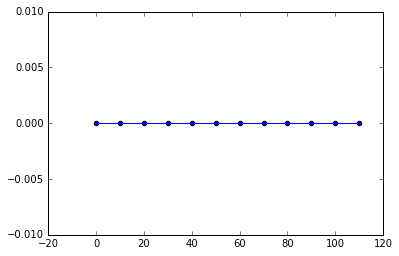

In [418]:
tester = ann([2,3,4,1])

gradW = [tester.gradient(([0,1],1)), tester.gradient(([1,0],1))]
xordata = [([1,0], [1]), ([0,0], [0]), ([0,1],[1]), ([1,1],[0])]

optimizer  = tester.msgd(xordata, loss="cross_entropy", lr=0.6, batchsize=2)
pltdat = interactive_plot(optimizer, 3000, freq=10)
plt.show()

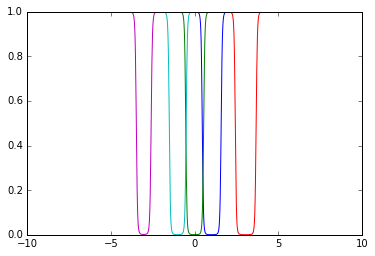

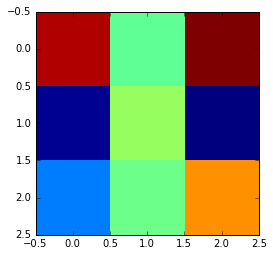

In [403]:

x = np.linspace(-10, 10, 1000)
y = np.array([tester.feed_forward([xi, 1]) for xi in x])
plt.plot(x, y)
y = np.array([tester.feed_forward([xi, 0]) for xi in x])
plt.plot(x, y)
y = np.array([tester.feed_forward([xi, 3]) for xi in x])
plt.plot(x, y)
y = np.array([tester.feed_forward([xi, -1]) for xi in x])
plt.plot(x, y)
y = np.array([tester.feed_forward([xi, -3]) for xi in x])
plt.plot(x, y)
plt.show()

plt.imshow(tester.W[0], interpolation='nearest')

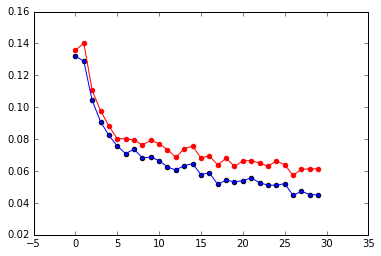

In [421]:
mnistNet = ann([784,100,10])

optimizer  = mnistNet.msgd(list(zip(X_tr,Y_tr)), loss="cross_entropy", lr=0.5, batchsize=10)
pltdat = interactive_plot(optimizer, 30, freq=1, comparison=validation_error(mnistNet))


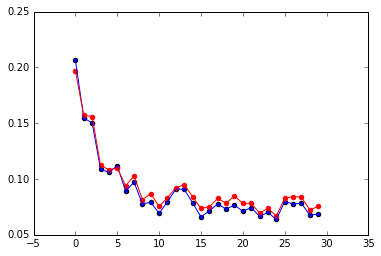

In [12]:
mnistNet = ann([784,200,10])

optimizer  = mnistNet.msgd(list(zip(X_tr,Y_tr)), loss="cross_entropy", lr=0.5, batchsize=10, decay=1)
pltdat = interactive_plot(optimizer, 30, freq=1, comparison=validation_error(mnistNet))

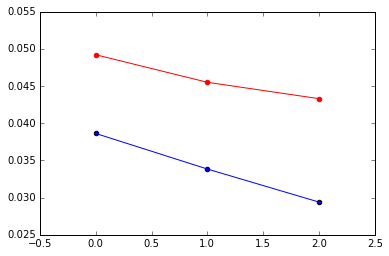

In [13]:
# drop out to a lower learning rate; let's be careful!
careful_optimizer  = mnistNet.msgd(list(zip(X_tr,Y_tr)), loss="cross_entropy", lr=0.25, batchsize=10, decay=1)
pltdat = interactive_plot(careful_optimizer, 3, freq=1, comparison=validation_error(mnistNet))

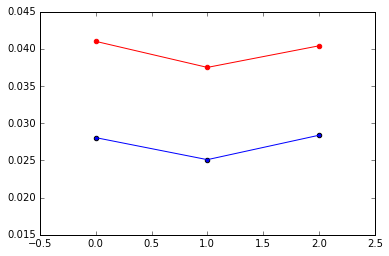

In [14]:
careful_optimizer  = mnistNet.msgd(list(zip(X_tr,Y_tr)), loss="cross_entropy", lr=0.25, batchsize=10, decay=1.5)
pltdat = interactive_plot(careful_optimizer, 3, freq=1, comparison=validation_error(mnistNet))

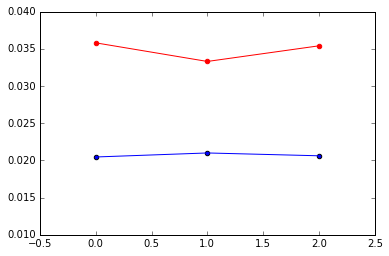

In [15]:
careful_optimizer  = mnistNet.msgd(list(zip(X_tr,Y_tr)), loss="cross_entropy", lr=0.20, batchsize=10, decay=1.5)
pltdat = interactive_plot(careful_optimizer, 3, freq=1, comparison=validation_error(mnistNet))

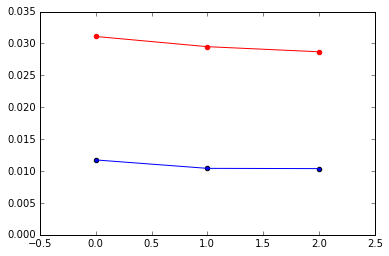

In [16]:
careful_optimizer  = mnistNet.msgd(list(zip(X_tr,Y_tr)), loss="cross_entropy", lr=0.15, batchsize=10, decay=1.5)
pltdat = interactive_plot(careful_optimizer, 3, freq=1, comparison=validation_error(mnistNet))

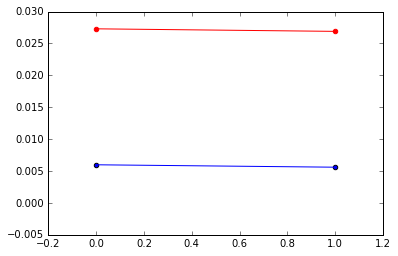

In [18]:
careful_optimizer  = mnistNet.msgd(list(zip(X_tr,Y_tr)), loss="cross_entropy", lr=0.10, batchsize=10, decay=1.5)
pltdat = interactive_plot(careful_optimizer, 3, freq=1, comparison=validation_error(mnistNet))

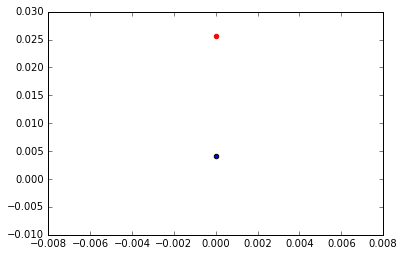

In [19]:
careful_optimizer  = mnistNet.msgd(list(zip(X_tr,Y_tr)), loss="cross_entropy", lr=0.07, batchsize=10, decay=1.5)
pltdat = interactive_plot(careful_optimizer, 3, freq=1, comparison=validation_error(mnistNet))

In [20]:
outp = list(map(lambda dp:  mnistNet.feed_forward(dp), X_te))

In [22]:
outp = list(map(lambda pred: np.argmax(pred), outp))

In [25]:
kaggle = pd.DataFrame(outp, columns=["Category"])

In [27]:
kaggle.to_csv('kaggle.csv')